In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


##  House Price Prediction using Random Forest

In this notebook, we use `RandomForestRegressor` from Sklearn to predict house prices using tabular data.  
We focus on preprocessing, tuning, and evaluating using RMSLE.

## Import the library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
sns.set()

## Load the dataset

In [3]:
train_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## EDA and visualisation 

Let's explore the training dataset to understand its structure, distribution of the target (`SalePrice`), and prepare for preprocessing.

In [4]:
df = train_df.copy()
df = df.drop('Id', axis=1) #ID makes no sense for our future analysis 
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df.info() #We can inspect the types of feature columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


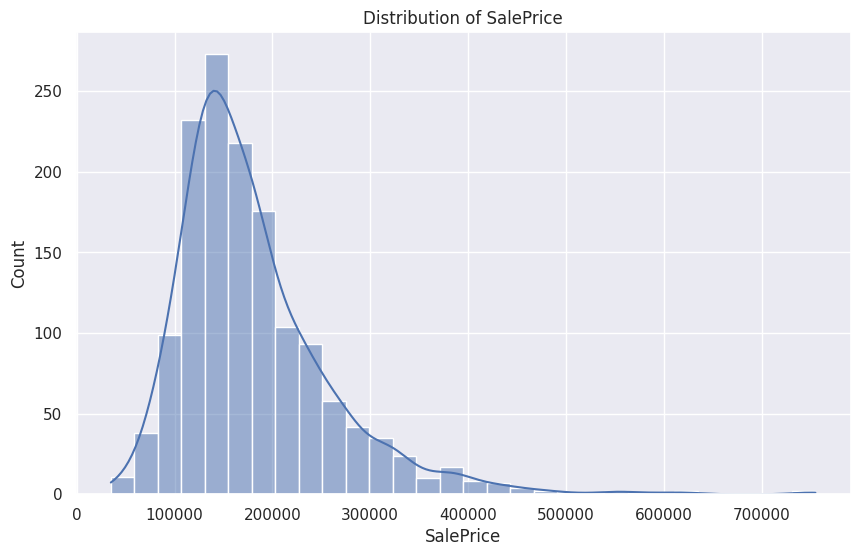

In [6]:
# Let's visualize the distribution of the target variable 'SalePrice'
# This helps us understand skewness, potential outliers, and overall spread
print(df['SalePrice'].describe())

plt.figure(figsize=(10,6))
sns.histplot(df['SalePrice'], kde=True, bins=30)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Count')
plt.show()

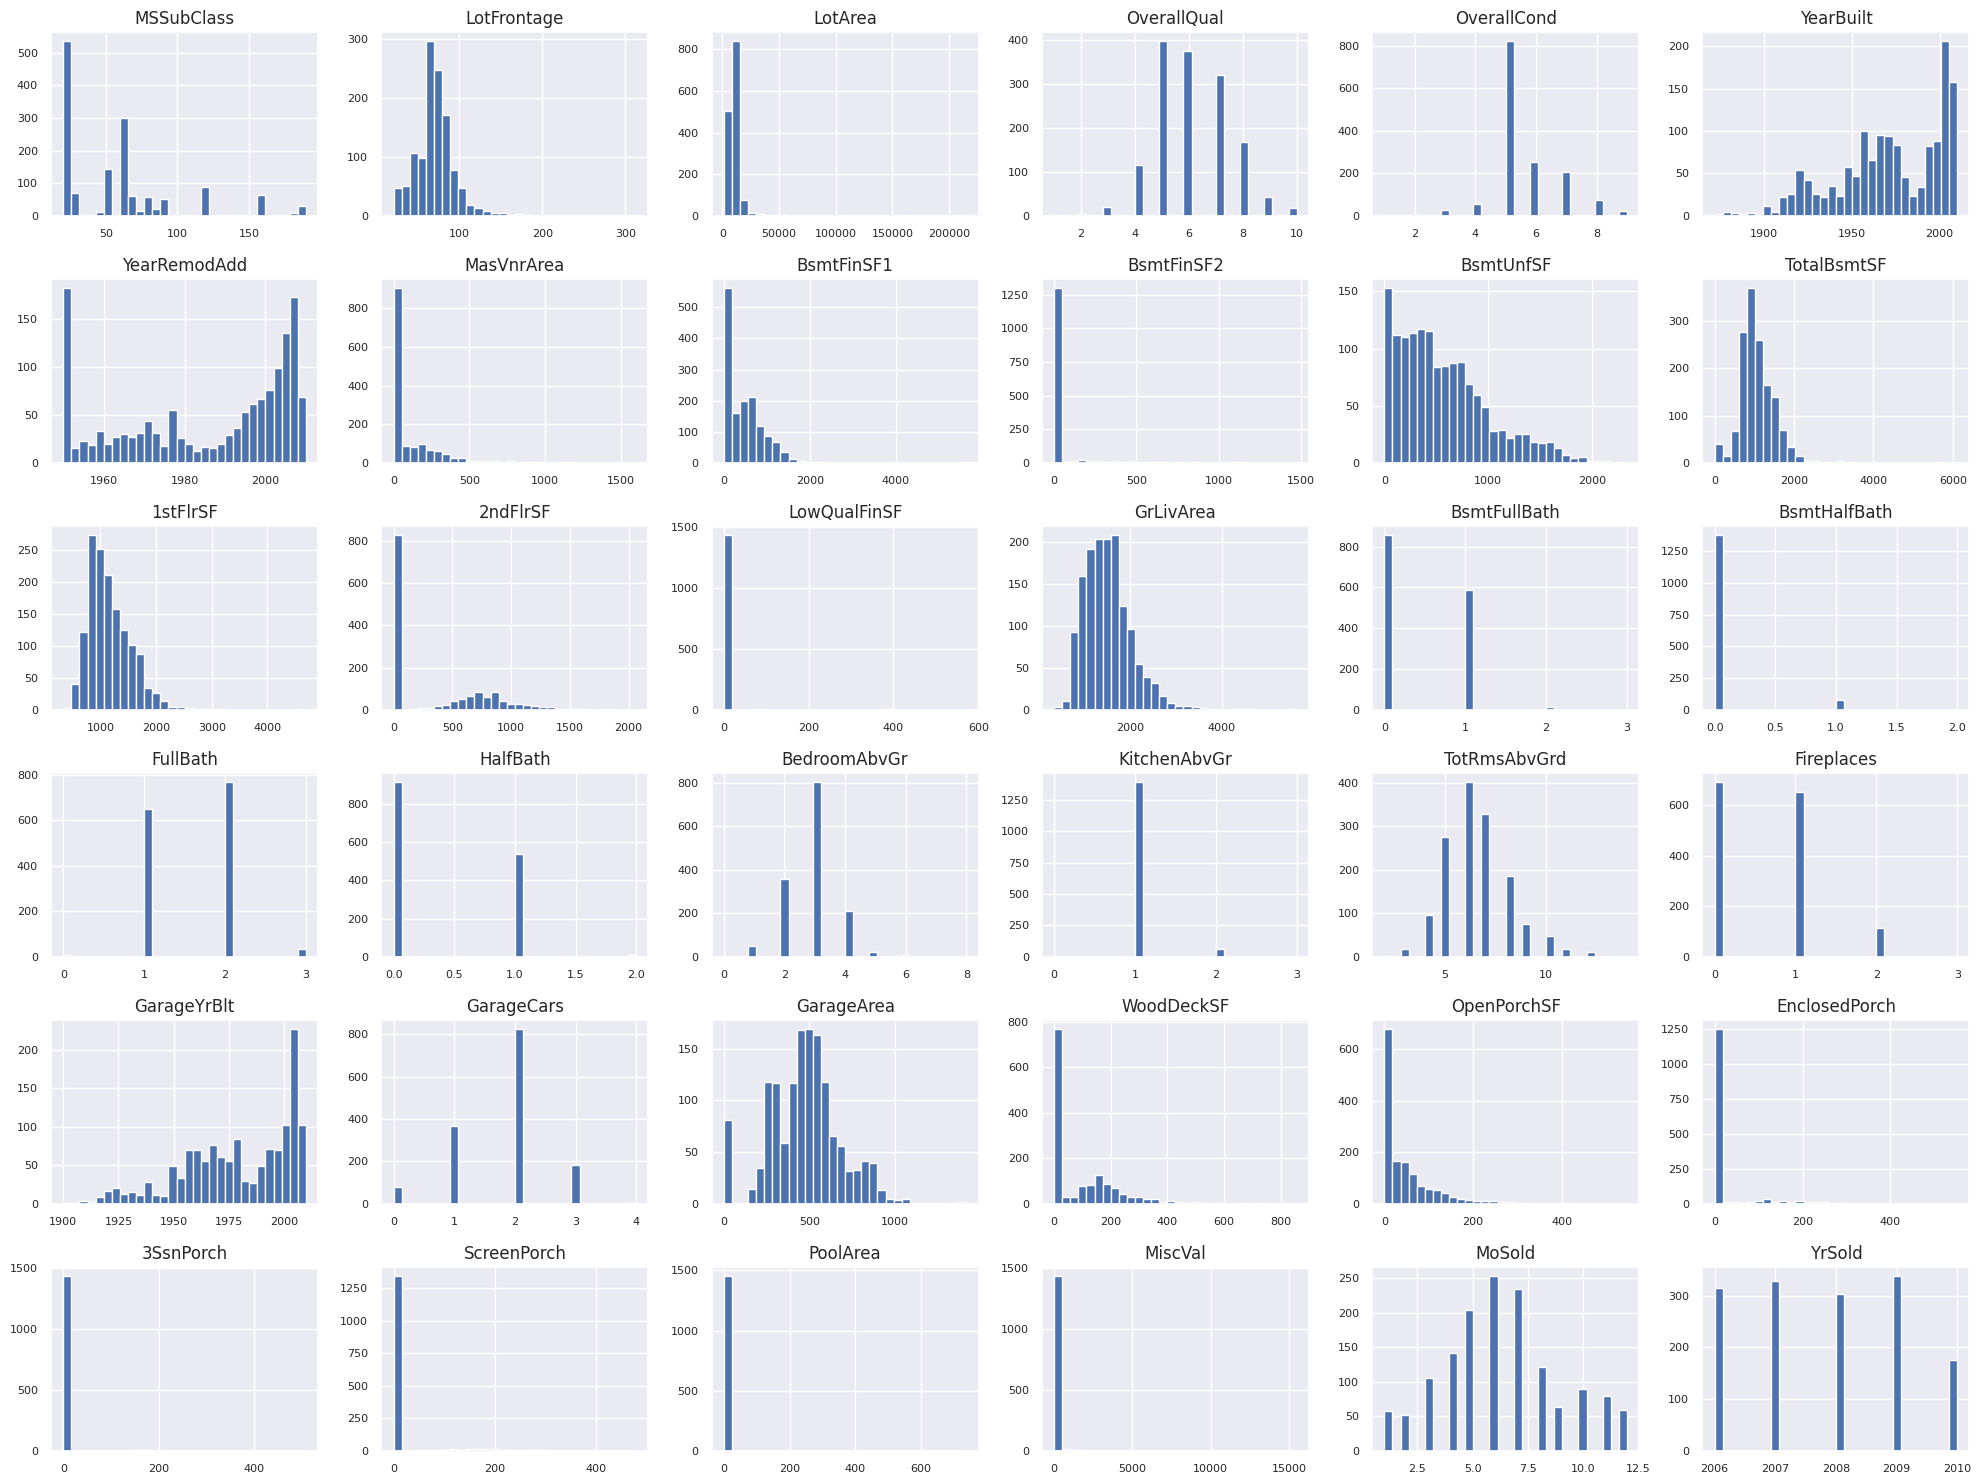

In [7]:
# Select all numerical columns except the target
num_df = df.select_dtypes(include=['int64', 'float64']).drop('SalePrice', axis=1)

# Plot histograms for each numerical feature
num_df.hist(bins=30, figsize=(20, 15), xlabelsize= 8, ylabelsize= 8)
plt.tight_layout()
plt.show()

In [8]:
# Count missing values in each column
missing_v = df.isnull().sum()

# Filter only columns with at least one missing value and sort them descending
missing_v[missing_v > 0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

##  Data Preprocessing: Handling Missing Values and Feature Selection

This dataset contains a mix of numeric, categorical and missing features. Before training our model, we need to handle missing data and remove features that are either too sparse or not informative.  
We'll also separate numerical and categorical columns for further preprocessing steps.


In [9]:
# Drop columns with a high percentage of missing values or low predictive power
df = df.drop(columns=["Alley", "PoolQC", "Fence", "MiscFeature"])

# Select numerical features (excluding the target 'SalePrice') and categorical features
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('SalePrice')
cat_cols = df.select_dtypes(include=['object']).columns

## Imputing Missing Values

To ensure our model can handle incomplete data, we fill missing values using appropriate strategies:


In [10]:
from sklearn.impute import SimpleImputer

# Create imputers: one for numerical (median), one for categorical (fill with 'Unknown')
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')

# Apply imputers to the corresponding columns and overwrite missing values
df[num_cols] = pd.DataFrame(num_imputer.fit_transform(df[num_cols]), columns=num_cols, index= df.index)
df[cat_cols] = pd.DataFrame(cat_imputer.fit_transform(df[cat_cols]), columns=cat_cols, index= df.index)

In [11]:
# Print the number of unique categories for each categorical feature (cardinality)
# Helps decide whether One-Hot Encoding is appropriate
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique values")

MSZoning: 5 unique values
Street: 2 unique values
LotShape: 4 unique values
LandContour: 4 unique values
Utilities: 2 unique values
LotConfig: 5 unique values
LandSlope: 3 unique values
Neighborhood: 25 unique values
Condition1: 9 unique values
Condition2: 8 unique values
BldgType: 5 unique values
HouseStyle: 8 unique values
RoofStyle: 6 unique values
RoofMatl: 8 unique values
Exterior1st: 15 unique values
Exterior2nd: 16 unique values
MasVnrType: 4 unique values
ExterQual: 4 unique values
ExterCond: 5 unique values
Foundation: 6 unique values
BsmtQual: 5 unique values
BsmtCond: 5 unique values
BsmtExposure: 5 unique values
BsmtFinType1: 7 unique values
BsmtFinType2: 7 unique values
Heating: 6 unique values
HeatingQC: 5 unique values
CentralAir: 2 unique values
Electrical: 6 unique values
KitchenQual: 4 unique values
Functional: 7 unique values
FireplaceQu: 6 unique values
GarageType: 7 unique values
GarageFinish: 4 unique values
GarageQual: 6 unique values
GarageCond: 6 unique values


## Encoding Categorical Variables

We now encode the cleaned categorical features using **One-Hot Encoding**.  
To prevent errors on unseen categories during inference, we use `handle_unknown='ignore'`.  
The final dataset is formed by combining numerical features with the encoded categorical features.


In [12]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit encoder on categorical columns and transform them into one-hot encoded array
cat_encoded = ohe.fit_transform(df[cat_cols])
encoded_cols = ohe.get_feature_names_out(cat_cols) # Get the names of the new one-hot encoded columns
df_cat_encoded = pd.DataFrame(cat_encoded, columns = encoded_cols, index=df.index) # Create a DataFrame from the encoded array, using the original index

# Concatenate numerical and encoded categorical features into a final dataset
df_final = pd.concat([df[num_cols], df_cat_encoded], axis=1)

print(df_final.shape)
df_final.head()

(1460, 286)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Log-Transforming the Target Variable

To reduce the skewness of the `SalePrice` distribution and improve model performance,  
we apply a log transformation to the target variable.  
The visualization below compares the original and log-transformed distributions.


In [13]:
# Define features (X) and apply log-transform to the target variable (y)
X = df_final
y = np.log(df['SalePrice'])

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


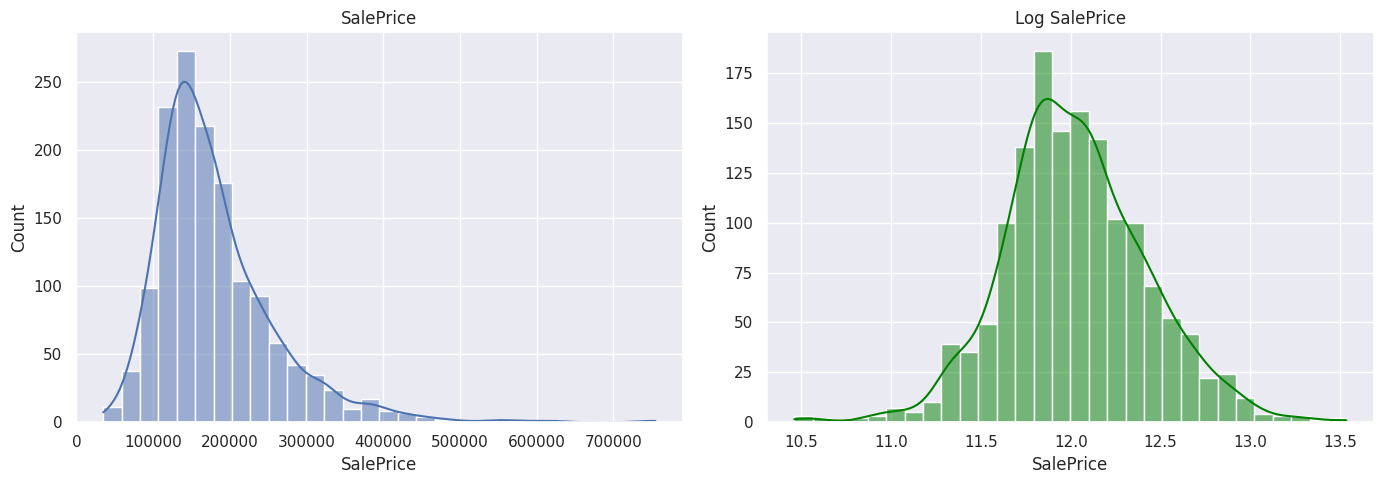

In [14]:
# Compare original vs log-transformed target distribution
plt.figure(figsize=(14, 5))

# Plot original SalePrice
plt.subplot(1, 2, 1)
sns.histplot(df["SalePrice"], kde=True, bins=30)
plt.title("SalePrice")

# Plot log-transformed SalePrice
plt.subplot(1, 2, 2)
sns.histplot(y, kde=True, bins=30, color='green')
plt.title("Log SalePrice")

plt.tight_layout()
plt.show()

The log-transformed `SalePrice` shows a more symmetrical and normalized distribution,  
helping the model to better learn patterns and reduce the impact of outliers.


## Model Evaluation and Hyperparameter Tuning

We split our dataset into training and validation sets and define a reusable function to evaluate model performance using RMSLE — a metric suitable for log-transformed targets.

Next, we perform a simple grid search over different values of `n_estimators` and `max_depth`  
to identify the best-performing Random Forest configuration.


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Define grid of hyperparameters
n_estimators_list = [30, 50, 100, 150]
max_depth_list = [5, 10, 15, 20]

# Define a reusable evaluation function based on RMSLE
def evaluate_model_rmsle(X_train, X_val, y_train, y_val, n_estimators, max_depth):
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict and reverse log transformation
    y_pred_log = model.predict(X_val)
    y_pred = np.exp(y_pred_log)
    y_val_true = np.exp(y_val)
    
    # Calculate Root Mean Squared Log Error
    rmsle = np.sqrt(mean_squared_log_error(y_val_true, y_pred))
    return rmsle

In [17]:
results = []

# Grid search: iterate over combinations of estimators and tree depth
for n in n_estimators_list:
    for d in max_depth_list:
        rmsle = evaluate_model_rmsle(X_train, X_val, y_train, y_val, n_estimators=n, max_depth=d)
        results.append({
            'n_estimators': n,
            'max_depth': d,
            'rmsle': rmsle
        })
        print(f"n={n}, depth={d} → RMSLE: {rmsle:.4f}")

n=30, depth=5 → RMSLE: 0.1641
n=30, depth=10 → RMSLE: 0.1457
n=30, depth=15 → RMSLE: 0.1509
n=30, depth=20 → RMSLE: 0.1521
n=50, depth=5 → RMSLE: 0.1642
n=50, depth=10 → RMSLE: 0.1471
n=50, depth=15 → RMSLE: 0.1486
n=50, depth=20 → RMSLE: 0.1496
n=100, depth=5 → RMSLE: 0.1632
n=100, depth=10 → RMSLE: 0.1446
n=100, depth=15 → RMSLE: 0.1451
n=100, depth=20 → RMSLE: 0.1454
n=150, depth=5 → RMSLE: 0.1623
n=150, depth=10 → RMSLE: 0.1447
n=150, depth=15 → RMSLE: 0.1447
n=150, depth=20 → RMSLE: 0.1450


In [18]:
# After evaluating all combinations of n_estimators and max_depth,  
# we select the model with the lowest RMSLE score.

results_df = pd.DataFrame(results)
best = results_df.loc[results_df['rmsle'].idxmin()]
print("\n Best Model:")
print(best)


 Best Model:
n_estimators    100.000000
max_depth        10.000000
rmsle             0.144598
Name: 9, dtype: float64


## Final Model Training

We retrain the best-performing Random Forest model on the entire training dataset using the selected hyperparameters.  

In [19]:
final_model =  RandomForestRegressor(n_estimators=100, max_depth =10, random_state =42)
final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

## Test Set Preparation and Testing our Model

We load and preprocess our new test dataset to match the structure of the training data.

In [20]:
# Load test dataset for final predictions
test_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Test Set Preprocessing

We apply the same preprocessing steps to the test dataset that were used for the training set:

In [21]:
# Make a copy of the test data and drop columns with too many missing values
df_test_processed = test_df.copy()
df_test_processed = df_test_processed.drop(columns=["Id", "Alley", "PoolQC", "Fence", "MiscFeature"])

# Impute missing numerical values using median strategy
df_test_processed[num_cols] = pd.DataFrame(
    num_imputer.transform(df_test_processed[num_cols]),
    columns=num_cols,
    index=df_test_processed.index
)

# Impute missing categorical values using 'Unknown'
df_test_processed[cat_cols] = pd.DataFrame(
    cat_imputer.transform(df_test_processed[cat_cols]),
    columns=cat_cols,
    index=df_test_processed.index
)

# Apply One-Hot Encoding to categorical columns
cat_encoded_test = ohe.transform(df_test_processed[cat_cols])
df_cat_encoded_test = pd.DataFrame(cat_encoded_test, columns=encoded_cols, index=df_test_processed.index)

# Combine numerical and encoded categorical features into final test set
df_test_final = pd.concat([df_test_processed[num_cols], df_cat_encoded_test], axis=1)

df_test_final.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,144.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60.0,78.0,9978.0,6.0,6.0,1998.0,1998.0,20.0,602.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,120.0,43.0,5005.0,8.0,5.0,1992.0,1992.0,0.0,263.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
# Check the shape of our training and testing datasets
print(df_final.shape)
print(df_test_final.shape)

(1460, 286)
(1459, 286)


## Model Predictions on Test Set

We use the trained model to make predictions on the test set and reverse the log transformation using `np.exp()`. Below is a comparison between the original training target distribution and our model’s predicted values.


In [23]:
y_test_pred_log = final_model.predict(df_test_final)
y_test_pred = np.exp(y_test_pred_log) # Convert predictions back from log scale to original scale
y_test_pred

array([127202.90065208, 154182.40775493, 176408.64608801, ...,
       152930.66200617, 115506.80598884, 227096.55639498])

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


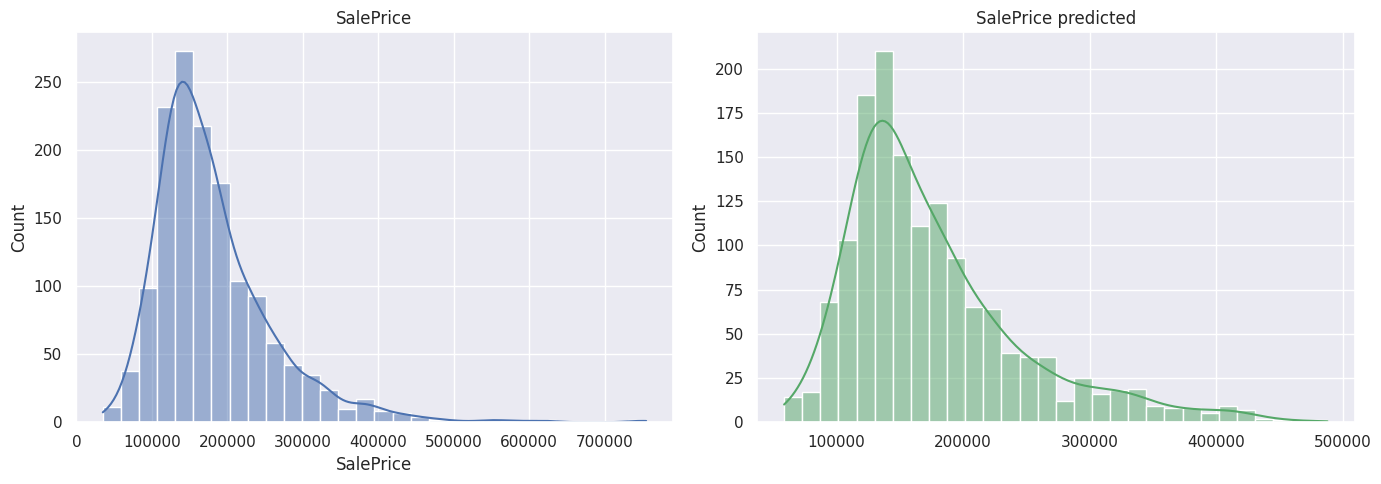

In [24]:
# Plot original vs predicted SalePrice distributions
plt.figure(figsize=(14, 5))

# Left plot: original SalePrice distribution from training data
plt.subplot(1, 2, 1)
sns.histplot(df["SalePrice"], kde=True, bins=30)
plt.title("SalePrice")

# Right plot: predicted SalePrice distribution from test data
plt.subplot(1, 2, 2)
sns.histplot(y_test_pred, kde=True, bins=30, color='g')
plt.title("SalePrice predicted")

plt.tight_layout()
plt.show()

## Submission

In [25]:
submission = pd.DataFrame({
    "Id": test_df["Id"], 
    "SalePrice": y_test_pred
})

submission.to_csv("submission.csv", index=False)

submission.head()

,Id,SalePrice
0,1461,127202.900652
1,1462,154182.407755
2,1463,176408.646088
3,1464,182564.983961
4,1465,197526.756655
